# Pd 4

Tematem tej pracy domowej jest zbadanie wrażliwości sieci na perturbacje
# Wrażliwośc sieci 
Wrażliwość sieci oznacza wpływ małych zmian w modelu na wyniki predykcji. W naszym przypadku badanie wrażliwości sieci sprowadza się do przeprowadzenia perturbacji w obrębie danych wejściowych, wag w pojedyńczej warstwie, oraz wag w całym modelu. Sprawdzimy jak wpłyną one na wyniki naszej sieci.

Źródło:[Hai Shu, Hongtu Zhu, Sensitivity Analysis of Deep Neural Networks, AAAI Conference on Artificial Intelligence](https://arxiv.org/abs/1901.07152)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD
from keras.layers import Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.utils import np_utils
from matplotlib import pyplot
import copy

## Zbiór danych 

Jako zbiór danych i bazowy model użyje danych i modelu z ostatniej pracy domowej. Będziemy mieć więc do czynienia ze zbiorem MNIST.
źródło kodu: https://keras.io/examples/vision/mnist_convnet/

In [2]:
batch_size = 32
epochs = 20
num_classes = 10
input_shape = (28, 28, 1)

(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype("float32") / 255
x_test = x_test.astype("float32") / 255
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
print("x_train shape:", x_train.shape)
print(x_train.shape[0], "train samples")
print(x_test.shape[0], "test samples")
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [3]:
def draw(k, im):
  for i in range(k):
    pyplot.subplot(330 + 1 + i)
    x = im[:, :, :, 0]
    pyplot.imshow(x[i], cmap=pyplot.get_cmap('gray'))
  # show the figure
  pyplot.show()

In [4]:
def base_model():
    model = Sequential()

    model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=x_train.shape[1:]))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64,(3,3),padding='same',activation='relu'))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Flatten())
    model.add(Dropout(0.2))
    model.add(Dense(32,activation='relu',kernel_constraint=maxnorm(3)))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])
    return model
cnn_n = base_model()
cnn_n.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dropout (Dropout)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 32)                1

Tak wyglądają metryki dla naszego modelu. Zobaczymy jaki wpływ na nie będą miały zmiany w danych wejściowych i wagach.

In [5]:
cnn = cnn_n.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(x_test,y_test),shuffle=True, verbose=0)
score = cnn_n.evaluate(x_test, y_test, verbose=0)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

Test loss: 0.0250687338411808
Test accuracy: 0.9922999739646912


## Perturbacje zbioru danych 
Zgodnie z treścią artukułu do iryginalnych danych dodaje wektor perturbacji. Jest to po prostu losowa macierz o wartościach z przedziału [0,1]. Dodatkowo wprowadziłem dzielnik, czyli po prostu wartość przez którą dziele macierz perturbacji. Im większy dzielnik tym mniejszy szum.

Poniżej narysowane są przykłądowe obrazki z różnym natężeniem szumu.

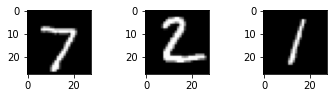

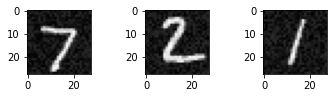

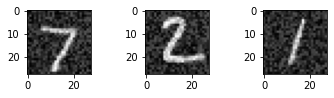

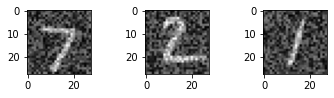

In [6]:
delta_x_test5 = x_test + np.random.rand(10000, 28, 28, 1) / 5
delta_x_test2 = x_test + np.random.rand(10000, 28, 28, 1) / 2
delta_x_test1 = x_test + np.random.rand(10000, 28, 28, 1)
draw(3, x_test)
draw(3, delta_x_test5)
draw(3, delta_x_test2)
draw(3, delta_x_test1)

In [7]:
def check_score(x, y, k, dzielnik):
  acc = []
  loss = []
  for i in range(k):
    # tworzymy wektor z szumem i testujemy go na sieci 
    delta_x = x + np.random.rand(10000, 28, 28, 1) / dzielnik
    score = cnn_n.evaluate(delta_x, y_test, verbose=0)
    acc.append(score[1])
    loss.append(score[0])
  print("Test average loss:", sum(loss)/ k, "standard deviation: ", np.std(loss))
  print("Test average accuracy:", sum(acc) / k, "standard deviation: ", np.std(acc))


In [8]:
print("Wynik dla szymu z dzielnikem 1")
check_score(x_test, y_test, 5, 1)
print("Wynik dla szymu z dzielnikem 1.3")
check_score(x_test, y_test, 5, 1.3)
print("Wynik dla szymu z dzielnikem 2")
check_score(x_test, y_test, 5, 2)
print("Wynik dla szymu z dzielnikem 5")
check_score(x_test, y_test, 5, 5)

Wynik dla szymu z dzielnikem 1
Test average loss: 6.5142333030700685 standard deviation:  0.02246220506835774
Test average accuracy: 0.22161999940872193 standard deviation:  0.0011142730207613842
Wynik dla szymu z dzielnikem 1.3
Test average loss: 1.9800097465515136 standard deviation:  0.022178233711441443
Test average accuracy: 0.5476400017738342 standard deviation:  0.002627992416462931
Wynik dla szymu z dzielnikem 2
Test average loss: 0.14363373219966888 standard deviation:  0.0022250853904188725
Test average accuracy: 0.9555399894714356 standard deviation:  0.0006280064755932859
Wynik dla szymu z dzielnikem 5
Test average loss: 0.028990302607417105 standard deviation:  0.0007017476823668545
Test average accuracy: 0.9912199974060059 standard deviation:  0.0003709471629349829


Sieć mocno pogarsza swoje wyniki, gdy dzielnik jest równy 1, a więc gdy szumy są największe. Wystarczy jednak delikatnie zmniejszyć natężenie szumu i już wynik sieci robi się dużo lepszy. Po zmianie dzielnika z 1 na 1.3 wynik sieci podskoczył z 0.24 na 0.85. Dla wyższych dizlników, czyli dla delikatnych perturbacji sieć prawie nie zmienia swojego wyniku.

## Perturbacje wag
Na początku zmodyfikujemy wagi w poszczególnych warstwach, następnie zobaczymy jak zmienią się wyniki sieci gdy zmienione zostaną wszystkie wagi 

Zapisujemy oryginalne wagi modelu, aby nie musieć ich od nowa trenować 

In [9]:
wagi_l1 = copy.deepcopy(cnn_n.layers[0].get_weights()[0])
wagi_l2 = copy.deepcopy(cnn_n.layers[2].get_weights()[0])
wagi_l3 = copy.deepcopy(cnn_n.layers[6].get_weights()[0])
wagi_l4 = copy.deepcopy(cnn_n.layers[8].get_weights()[0])

### Zmiany w warstwach konwolucyjnych

Modyfikując wagi dodajemy do odpowiednich macierzy macierz losową o wartościach z przedziału 0-1. Dodatkowo wprowadziłem dzielnik, czyli wartość przez którą dzielimy całą macierz perturbacji. W zależności od dzielnika szum będzie sie zmieniał. Im większy dzielnik tym mniejszy szum.




In [10]:
def change_conv(layer, weight,  dzielnki, k):
  a, b, c, d = cnn_n.layers[layer].get_weights()[0].shape
  for dziel in dzielnki:
    acc = []
    print("Szum z dzielnikem ", dziel)
    for i in range(k):
      # Tworzymy wektor z szumem 
      delta_weights = cnn_n.layers[layer].get_weights()[0] + np.random.rand(a, b, c, d) / dziel
      cnn_n.layers[layer].set_weights([delta_weights, cnn_n.layers[layer].get_weights()[1]]) 

      # Testujemy sieć na zmienionych wagach, a następnie ustawiamy znowu włąściwe wagi 
      score = cnn_n.evaluate(x_test, y_test, verbose=0)
      acc.append(score[1])
      cnn_n.layers[layer].set_weights([weight, cnn_n.layers[layer].get_weights()[1]])
    print("Average accuracy: ", sum(acc)/k, "standard deviation: ", np.std(acc))


In [11]:
change_conv(0, wagi_l1, [1, 5, 10], 5)

Szum z dzielnikem  1
Average accuracy:  0.25073999762535093 standard deviation:  0.02704407841633448
Szum z dzielnikem  5
Average accuracy:  0.7562000155448914 standard deviation:  0.021802654076011726
Szum z dzielnikem  10
Average accuracy:  0.9651399970054626 standard deviation:  0.007883034998619226


In [12]:
change_conv(2, wagi_l2, [1, 5, 10], 5)

Szum z dzielnikem  1
Average accuracy:  0.3570800006389618 standard deviation:  0.009786809785284626
Szum z dzielnikem  5
Average accuracy:  0.6971799969673157 standard deviation:  0.0033582084302031757
Szum z dzielnikem  10
Average accuracy:  0.9690999984741211 standard deviation:  0.0014142223289617987


Szumy w warstwach konwolucyjnych wpłyneły znacząco na wyniki sieci. Druga warstwa wydaje się być bardziej czuła na zmiany. Ma natomiast nieco lepsze wyniki gdy zmiany są niewielkie. 

## Perturbacje dla warstw gęstych 

In [13]:
def change_dense(layer, weight,  dzielnki, k):
  a, b = cnn_n.layers[layer].get_weights()[0].shape
  for dziel in dzielnki:
    acc = []
    print("Szum z dzielnikem ", dziel)
    for i in range(k):
      delta_weights = cnn_n.layers[layer].get_weights()[0] + np.random.rand(a, b) / dziel
      cnn_n.layers[layer].set_weights([delta_weights, cnn_n.layers[layer].get_weights()[1]]) 

      score = cnn_n.evaluate(x_test, y_test, verbose=0)
      acc.append(score[1])
      cnn_n.layers[layer].set_weights([weight, cnn_n.layers[layer].get_weights()[1]])
    print("Average accuracy: ", sum(acc)/k, "standard deviation: ", np.std(acc))

In [14]:
change_dense(6, wagi_l3, [1, 2, 5, 10, 15], 6)

Szum z dzielnikem  1
Average accuracy:  0.10090000182390213 standard deviation:  0.0
Szum z dzielnikem  2
Average accuracy:  0.10091666877269745 standard deviation:  3.726843048384063e-05
Szum z dzielnikem  5
Average accuracy:  0.19695000102122626 standard deviation:  0.016082783348899725
Szum z dzielnikem  10
Average accuracy:  0.7238333423932394 standard deviation:  0.011431637146038513
Szum z dzielnikem  15
Average accuracy:  0.8603666623433431 standard deviation:  0.004213329568969608


In [15]:
change_dense(8, wagi_l4, [1, 2, 5, 10], 6)

Szum z dzielnikem  1
Average accuracy:  0.9731166561444601 standard deviation:  0.013278983105768674
Szum z dzielnikem  2
Average accuracy:  0.9898833334445953 standard deviation:  0.0014937946519565687
Szum z dzielnikem  5
Average accuracy:  0.991866668065389 standard deviation:  0.0002560392929711884
Szum z dzielnikem  10
Average accuracy:  0.9923500021298727 standard deviation:  0.00016072946139876


Dla warst gęstych dostajemy bardzo ciekawe informację. Przedostatnia warstwa jest bardzo wrażliwa na zmiane wag dawet nieduże perturbacje znacząco obniżąją wynik sieci. Wagi w ostatniej warstwie natomiast są bardzo odporne na zakłucenia. Przy dużym dzielniku różnice są niemal niezauważalne, natomiast przy małym dzielniku, a więc i przy dużym szumie wynik spada nieznacznie. Można przypuszczać że na tym etapie sieć juz jest "zdecydowana", więc zmiany wag na tym etapie nie wpływają znacząco na jej wynik. Jest to oczywiście tylko moja intuicja.

## Perturbacje dla wszytkich wag modelu

In [16]:
def test_all_wegihts(dzielnik, k):
  for dziel in dzielnik:
    acc = []
    print("Szum z dzielnikem ", dziel)
    for i in range(k):
      a, b, c, d = cnn_n.layers[0].get_weights()[0].shape
      delta_weights = cnn_n.layers[0].get_weights()[0] + np.random.rand(a, b, c, d) / dziel
      cnn_n.layers[0].set_weights([delta_weights, cnn_n.layers[0].get_weights()[1]]) 
      a, b, c, d = cnn_n.layers[2].get_weights()[0].shape
      delta_weights = cnn_n.layers[2].get_weights()[0] + np.random.rand(a, b, c, d) / dziel
      cnn_n.layers[2].set_weights([delta_weights, cnn_n.layers[2].get_weights()[1]])
      a, b = cnn_n.layers[6].get_weights()[0].shape
      delta_weights = cnn_n.layers[6].get_weights()[0] + np.random.rand(a, b) / dziel
      cnn_n.layers[6].set_weights([delta_weights, cnn_n.layers[6].get_weights()[1]])
      a, b = cnn_n.layers[8].get_weights()[0].shape
      delta_weights = cnn_n.layers[8].get_weights()[0] + np.random.rand(a, b) / dziel
      cnn_n.layers[8].set_weights([delta_weights, cnn_n.layers[8].get_weights()[1]])

      # Wyliczanie wyniku
      score = cnn_n.evaluate(x_test, y_test, verbose=0)
      acc.append(score[1])
      cnn_n.layers[0].set_weights([wagi_l1, cnn_n.layers[0].get_weights()[1]])
      cnn_n.layers[2].set_weights([wagi_l2, cnn_n.layers[2].get_weights()[1]])
      cnn_n.layers[6].set_weights([wagi_l3, cnn_n.layers[6].get_weights()[1]])
      cnn_n.layers[8].set_weights([wagi_l4, cnn_n.layers[8].get_weights()[1]])
    print("Average accuracy: ", sum(acc)/k, "standard deviation: ", np.std(acc))

In [17]:
test_all_wegihts([5, 10, 12, 15, 20, 60], 3)

Szum z dzielnikem  5
Average accuracy:  0.11863333483537038 standard deviation:  0.01938149448753716
Szum z dzielnikem  10
Average accuracy:  0.19933333496252695 standard deviation:  0.0028429240285538205
Szum z dzielnikem  12
Average accuracy:  0.4240333338578542 standard deviation:  0.04253346785760322
Szum z dzielnikem  15
Average accuracy:  0.7086333235104879 standard deviation:  0.01839516733349231
Szum z dzielnikem  20
Average accuracy:  0.8396000067392985 standard deviation:  0.0037478920992934646
Szum z dzielnikem  60
Average accuracy:  0.9900333484013876 standard deviation:  4.714827453418679e-05


Dla zmian we wszystkich wagach rezultaty sa dużo gorsze. Wyniki zaczynają się poprawiać dopiero gdy dzielnik jest równy 15. Nawet dleikatne zmiany, ale przeprowadzone na wszystkich wagach modelu mają duży wpływ na koncowy wynik sieci.

## Wnioski 
Warstwy konwolucyjne okazały się być bardziej odporne na perturbacje niż warstwa gęsta. Szokujące było natomiast, że ostatnia warstwa gęsta była bardzo odporna na szumy, w przeciwieństwie od wewnętrznej warstwy gęstej. Zmiany w danych również wpłyneły znacząco na wyniki sieci. Jednak rezultaty w przypadku perturbacji danych wejściowych wahały się znacząco w zależności od natężenia szumów.